In [2]:
import seaborn as sns;sns.set(style="ticks", color_codes=True)
import umap.umap_ as umap
%matplotlib inline
%run scripts.py
from sklearn import preprocessing
from matplotlib.lines import Line2D
import numba

# redefining groups
* Hot Jupiters: $P < 10$ d, $ R > 0.8 R_J$

* Long period Giants: $R > 0.8 R_J$, $P>100$d

* Super Earths: $R \in [1.5, 3.8] R_{Earth}$, $P<100$d

alternatively sub-Neptunes from $R \in [2.5,3.8] R_{Earth}$

* Rocky planets: $1.5 < R/R_{Earth}$, $P<100$d

* Hot Neptunes $R \in [3.8,9] R_{Earth}$, $P<10$d or $a < 0.5 AU$

* Dense Super Earths: 

In order to visualize data, we plot a pairplot, showing the relationships between every 2 variables. The diagonals represent density distributions for each parameter

<u>On Neptunes:</u> info from Montañés-Rodríguez & Pallé (2017)

Neptunes: $M \in [0.03,1]M_J $
* Hot Neptunes: $a < 0.5 AU$, comprise 13% of known exoplanets

try: P<10d, $R \in [0.3,0.8]R_J$

Sub-Neptunes: $M \in [M_{Earth}, M_{Nep}]$
* Approximately 30% of sunlike stars host sub-Neptunes with P<100d 

(overlaps with super earths)


# UMAP trial 2 - Dimension Reduction


In [3]:
param_Teff=['obj_orb_period_day','obj_phys_radius_rjup','obj_phys_mass_mjup','obj_parent_phys_radius_rsun','obj_parent_phys_teff_k','obj_parent_phys_mass_msun']
data_US = exo_sol(file_EU,cat_solar,param_Teff)
add_lumi(data_US)

data_US['density'] = data_US.obj_phys_mass_mjup/((4/3)*np.pi*data_US.obj_phys_radius_rjup**3)
data_US = earthUnits(data_US)
params_Teff=['obj_orb_period_day','obj_phys_radius_rearth','obj_phys_mass_mearth','obj_parent_phys_radius_rsun','obj_parent_phys_teff_k','obj_parent_phys_mass_msun']

data_US[params_Teff] = np.log10(data_US[params_Teff])
data_US.density = np.log10(data_US.density)
data_US.luminosity = np.log10(data_US.luminosity)
len(data_US)

738

In [4]:
#por isto nos scripts
data=data_US.reset_index()
data['number']=np.ones(len(data),int)

e_gts = data[(data.obj_phys_radius_rearth>=np.log10(9))&(data.obj_orb_period_day>=1.4)]
hotjups = data[(data.obj_phys_radius_rearth>=np.log10(8.5))&(data.obj_orb_period_day<=1.1)]
dense = data[(data.density>=np.log10(.8))&(data.obj_phys_radius_rearth>np.log10(1.8))&(data.obj_phys_radius_rearth<=np.log10(3.8))]
s_earths = data[(data.density<np.log(.8))&(data.obj_phys_radius_rearth>np.log10(1.8))&(data.obj_phys_radius_rearth<=np.log10(3.8))]
hotneps = data[(data.density<=np.log(.8))&(data.obj_phys_radius_rearth<np.log10(8))&(data.obj_phys_radius_rearth>=np.log10(3.8))]
rocky = data[(data.density>=np.log(0.8))&(data.density<=np.log(2))&(data.obj_phys_radius_rearth<np.log10(1.8))]

group_names = ['L. Period Giants','Hot Jupiters','Gaseous S. Earths','Rocky S. Earths','Neptune-like','Earth-like']
names = [e_gts, hotjups, s_earths,  dense, hotneps, rocky]

print("Total planets", len(data), "Total labeled",len(pd.concat(names)))
for i,n in enumerate(names):
    print(group_names[i],len(n))

Total planets 738 Total labeled 657
L. Period Giants 26
Hot Jupiters 404
Gaseous S. Earths 64
Rocky S. Earths 55
Neptune-like 49
Earth-like 59


In [5]:
for i in range(6):
    names[i].number*=i
data_labeled=pd.concat(names)

name_tags = []
for i,l in enumerate(data_labeled.number):
    name_tags = np.append(name_tags, group_names[l])
data_labeled['tag']=name_tags

/usr/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


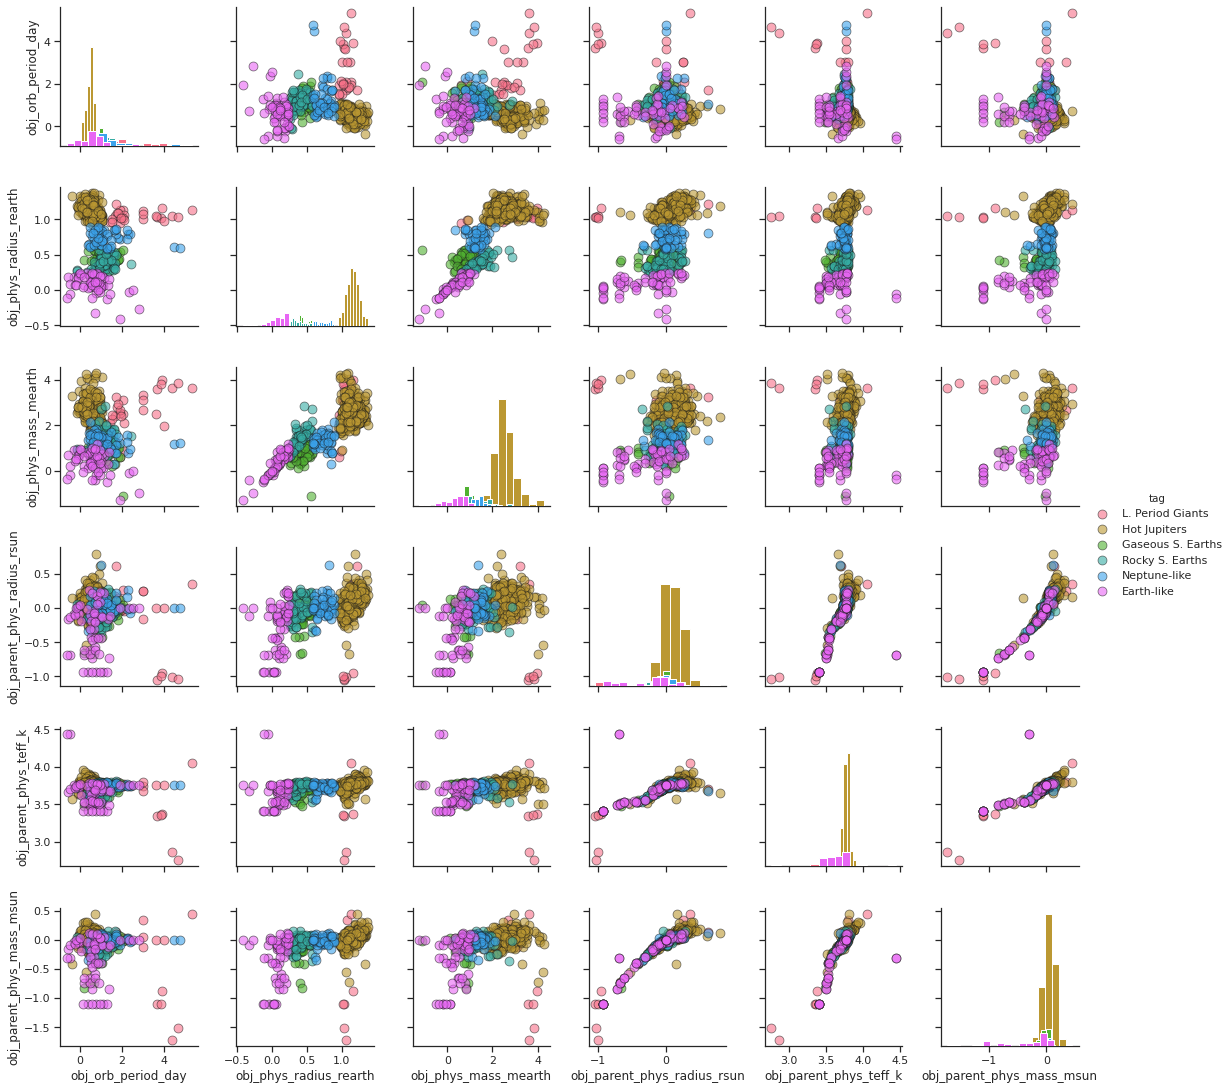

In [7]:
params=['obj_orb_period_day','obj_phys_radius_rearth','obj_phys_mass_mearth','obj_parent_phys_radius_rsun','obj_parent_phys_teff_k','obj_parent_phys_mass_msun']
sns.pairplot(data_labeled, vars = params, hue='tag', diag_kind='hist',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             palette="husl")
plt.savefig("ppt-color.pdf",dpi=1000,bbox_inches='tight')

In [9]:
data_US2 = data_US[params]
x = data_US.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_US_scaled = pd.DataFrame(x_scaled)

In [16]:
reducer = umap.UMAP(n_neighbors=80, min_dist=0.02, metric='euclidean')
embedding_scaled = reducer.fit_transform(data_US_scaled)
embedding_scaled.shape

(738, 2)

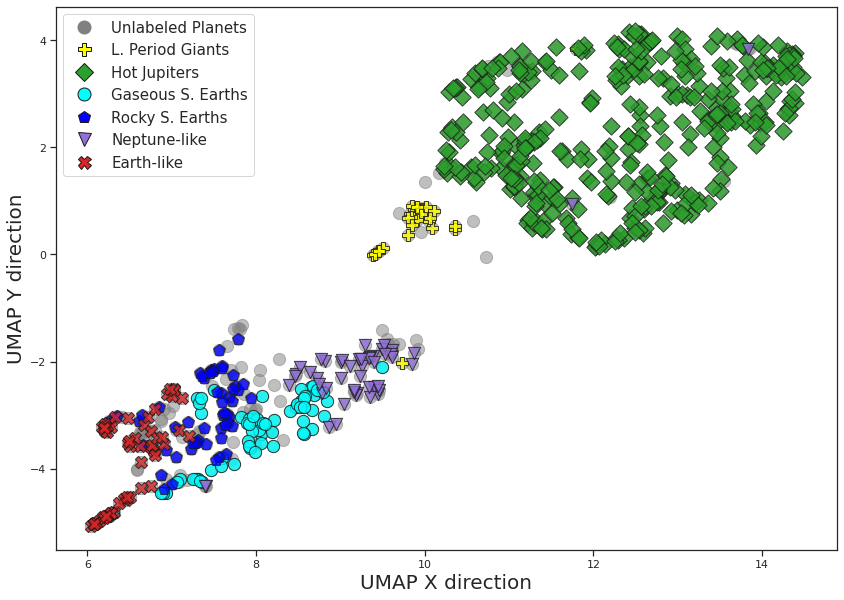

In [17]:
color = ['yellow','tab:green','cyan','blue','mediumpurple','tab:red']
marker = ['P','D','o','p','v','X']
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding_scaled.T, s=150, c='grey',marker='o', alpha=0.5)

legend_elements = [Line2D([0], [0], c='grey',marker='o',lw=0,label='Unlabeled Planets',markersize=13)]
for i in range(6):
    legend_elements = np.append(legend_elements, Line2D([0], [0],lw=0,c=color[i],marker=marker[i],mec='k',markersize=13))
    group=names[i]
    plt.scatter(*embedding_scaled[np.array(group.index)].T,s=150,c=color[i],marker=marker[i],edgecolor='k',cmap='viridis',alpha=0.8)
plt.ylabel('UMAP Y direction',fontsize=20)
plt.xlabel('UMAP X direction',fontsize=20)
plt.legend(legend_elements, np.append(['Unlabeled Planets'],group_names), loc='best',fontsize=15)
#plt.xticks([])
#plt.yticks([])
#plt.xlim(7.6,7.7)
plt.savefig("feh.pdf",dpi=1000,bbox_inches='tight')
plt.show()

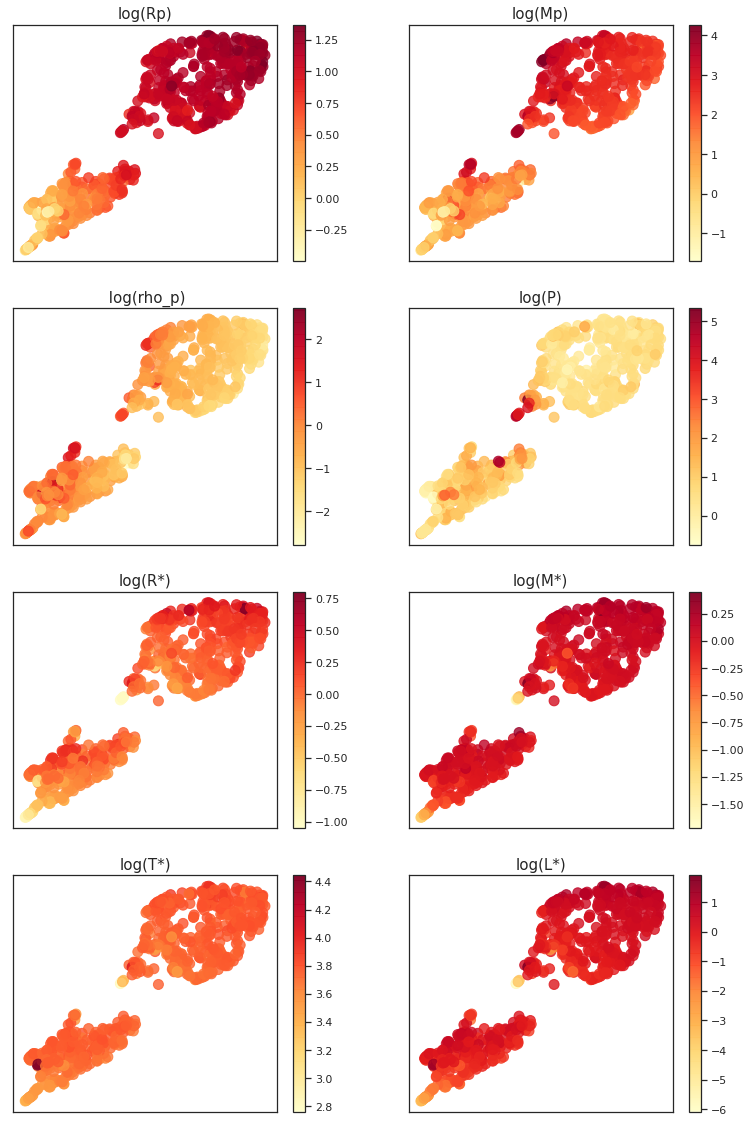

In [19]:
cols=[data_US.obj_phys_radius_rearth, data_US.density,data_US.obj_parent_phys_radius_rsun,data_US.obj_parent_phys_teff_k]
col_name = ['log(Rp)',' log(rho_p)', 'log(R*)', 'log(T*)']
cols2=[data_US.obj_phys_mass_mearth, data_US.obj_orb_period_day, data_US.obj_parent_phys_mass_msun, data_US.luminosity]
col_name2 = ['log(Mp)', 'log(P)', 'log(M*)','log(L*)']
fig, ax = plt.subplots(4,2, figsize=(13, 20))
for i, col in enumerate(cols):
    plot1 = ax[i,0].scatter(*embedding_scaled.T, s=100, c=col, cmap='YlOrRd', alpha=0.8)
    ax[i,0].set_title(col_name[i],fontsize=15)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = fig.colorbar(plot1,ax=ax[i,0])
    plot2 = ax[i,1].scatter(*embedding_scaled.T, s=100, c=cols2[i], cmap='YlOrRd', alpha=0.8)
    ax[i,1].set_title(col_name2[i],fontsize=15)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = fig.colorbar(plot2,ax=ax[i,1])
plt.savefig("MRPd+MRT-all.pdf",dpi=1000,bbox_inches='tight')

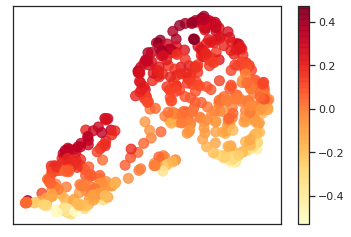

In [21]:
plt.scatter(*embedding_scaled.T, s=100, c=data_US.obj_parent_phys_feh, cmap='YlOrRd', alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig("feh-only.pdf",dpi=1000,bbox_inches='tight')

# Understanding the results: outliers and subgroups

In [20]:
#earth/solar units
for i,n in enumerate(names):
    print(group_names[i],"N =",len(n),'| med density','{:0.2f}'.format(np.median(10**names[i].density)),"| med period",'{:6.2f}'.format(np.median(10**names[i].obj_orb_period_day)),"| med lumi",'{:0.2f}'.format(np.median(10**names[i].luminosity)),"| med m*",'{:0.2f}'.format(np.median(10**names[i].obj_parent_phys_mass_msun)))
    print("              med r_p",'{:0.2f}'.format(np.median(10**names[i].obj_phys_radius_rearth)),"| med m_p",'{:0.2f}'.format(np.median(10**names[i].obj_phys_mass_mearth)),"| med r*",'{:0.2f}'.format(np.median(10**names[i].obj_parent_phys_radius_rsun)),"| med T*", '{:0.2f}'.format(np.median(10**names[i].obj_parent_phys_teff_k)))

L. Period Giants N = 26 | med density 0.38 | med period 120.29 | med lumi 0.86 | med m* 0.99
              med r_p 11.04 | med m_p 471.98 | med r* 0.96 | med T* 5600.00
Hot Jupiters N = 404 | med density 0.12 | med period   3.36 | med lumi 1.73 | med m* 1.13
              med r_p 14.12 | med m_p 313.06 | med r* 1.22 | med T* 5898.00
Gaseous S. Earths N = 64 | med density 0.38 | med period  12.05 | med lumi 0.74 | med m* 0.91
              med r_p 2.67 | med m_p 6.52 | med r* 0.94 | med T* 5455.50
Rocky S. Earths N = 55 | med density 1.68 | med period  13.86 | med lumi 0.71 | med m* 0.95
              med r_p 2.31 | med m_p 21.93 | med r* 0.90 | med T* 5417.00
Neptune-like N = 49 | med density 0.17 | med period  10.50 | med lumi 0.92 | med m* 0.98
              med r_p 5.41 | med m_p 21.10 | med r* 1.00 | med T* 5597.00
Earth-like N = 59 | med density 1.24 | med period   4.76 | med lumi 0.26 | med m* 0.71
              med r_p 1.26 | med m_p 2.86 | med r* 0.68 | med T* 4809.00


In [23]:
##Hot juptiter outlier
#different raneg for each map
#out_jup=np.where((embedding_scaled[:,1]>-3.59)&(embedding_scaled[:,1]<-3.58))
#10**data_US.iloc[out_jup]

In [24]:
## Hot neptune outlier, lower
#out_nep1=np.where((embedding_scaled[:,1]>-7)&(embedding_scaled[:,1]<-6.8)&(embedding_scaled[:,0]>4.19)&(embedding_scaled[:,0]<4.2))
#10**data_US.iloc[out_nep1]

In [78]:
##Hot neptune outlier, upper (close to HJ)

out_nep2=np.where((embedding_scaled[:,0]>12.17)&(embedding_scaled[:,0]<12.18))
10**data_US.iloc[out_nep2]

Planet,obj_parent_phys_radius_rsun,obj_parent_phys_teff_k,obj_parent_phys_mass_msun,log_obj_orb_period_day,luminosity,obj_phys_mass_mearth,obj_phys_radius_rearth,density
Kepler-56 b,4.23,4840.0,1.32,10.5016,8.809516,22.247988,6.501209,0.019329


In [39]:
#lower LP giants
#lefte_gts=np.where((embedding_scaled[:,1]>-1.65)&(embedding_scaled[:,1]<-1)&(embedding_scaled[:,0]>9.5)&(embedding_scaled[:,0]<9.75))
#lower_egts=10**data_US.iloc[lefte_gts]
#print("avg density",np.average(lower_egts.density),"median period",np.median(lower_egts.log_obj_orb_period_day),"avg luminosity",np.average(lower_egts.luminosity),"avg m*",np.average(lower_egts.obj_parent_phys_mass_msun))
#lower_egts

In [40]:
#upper long period giants
#righte_gts_index = np.where((embedding_scaled[:,0]>8)&(embedding_scaled[:,0]<9.8)&(embedding_scaled[:,1]>-1)&(embedding_scaled[:,1]<1))
#right_egts = 10**data_US.iloc[righte_gts_index]
#upper_egts = right_egts[(right_egts.log_obj_orb_period_day>=100)&(right_egts.obj_phys_mass_mearth>8)]
#print("avg density",np.average(upper_egts.density),"median period",np.median(upper_egts.log_obj_orb_period_day),"avg luminosity",np.average(upper_egts.luminosity),"avg m*",np.average(upper_egts.obj_parent_phys_mass_msun))
#upper_egts

# Comparing [FeH] average values

In [26]:
#hotjups_feh=hotjups.obj_parent_phys_feh
#print("avg hotjups =",np.average(hotjups_feh))

In [24]:
#notjups = pd.concat([e_gts, hotneps, s_earths, rocky, dense])
#notjups_feh = notjups.obj_parent_phys_feh
#print("avg not jups =",np.average(notjups_feh))

avg not jups = 0.036544378698224855


In [26]:
giants=pd.concat([e_gts,hotjups,hotneps])
giants_feh=giants.obj_parent_phys_feh
ungiants=pd.concat([rocky,dense,s_earths])
ungiants_feh=ungiants.obj_parent_phys_feh

print("avg ungiants =",np.average(ungiants_feh),"avg giants =",np.average(giants_feh))

avg ungiants = 0.010534482758620694 avg giants = 0.07134351145038167


In [27]:
#denser super earths
10**dense[['obj_phys_mass_mearth','obj_phys_radius_rearth','density']]

Planet,obj_phys_mass_mearth,obj_phys_radius_rearth,density
40,530.773439,3.698964,11.093946
44,24.504570,2.629627,1.425548
67,4.608512,1.804646,0.829472
80,31.782841,2.241796,2.984155
82,66.743965,3.362694,1.856808
94,16.685991,2.591516,1.014162
111,34.961125,3.269660,1.058022
125,8.263539,2.017617,1.064308
146,8.590902,1.947000,1.231283
166,10.710817,1.950363,1.527192
